Introduction
--------------------
This homework is programming based, where you must use Python to explore the fitting and generalization of regression models via simulation.  
Suppose that $Y$ and $Y$ are both real valued random variables, where $X$ takes value in $(0, 1)$ and $Y$ depends on $X$ according to

>$$Y = cos(2 \pi X) + Z ..................... (1)$$  

where $Z$ is a zero mean Gaussian random variable with variance $\sigma$, and $Z$ is independent of $X$. But assume
that you do not know this dependency of $Y$ on $X$ and that you only observe a sample of $N (X, Y)$ pairs.
Based on the observed sample, you must learn a polynomial regression model and examine the fitting and
generalization capability of your model in relation to the model complexity and sample size.  
Below detailed instructions are given to guide you through this exercise. These instructions only serve as a guideline, which your implementation need not to rigorously follow. You must use Python to write your code. It is fine and encouraged, but NOT compulsory, if you use a Python package that does automatic differentiation. But you must implement manually gradient-based optimization. That is, the
use of the package is only for you to compute the required gradients and you must manually code up the update of model parameters. You need to submit the following deliverables.  
* All Python code
* A concise report explaining your findings.

In [2]:
import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We need DCG_node to check all attributes

In [3]:
def DCG_node(listValue):
    for (i, v) in enumerate(listValue):
        print(f"{i}.data: {v.data}\n{i}.requires_grad: {v.requires_grad}\n{i}.grad: {v.grad}\n{i}.grad_fn: {v.grad_fn}\n{i}.is_leaf: {v.is_leaf}\n")

getData
---------------------------
Write a function **getData** that generates a dataset ${(x_i, y_i) : i = 1, 2, ... N}$ g of $N (X, Y)$ pairs for a given value of $N$ and $\sigma$. The $X$ values are drawn uniformly at random from $(0, 1)$ and the corresponding $Y$ values are generated according to (1).  
The dataset created by **getData** will then be used to fit your regression models. Of course, in the design of your regression model, you should assume no knowledge on how the dataset is generated.  
The regression models we consider will be exclusively polynomial models, namely, predicts $Y$ from $X$ according to
$$Y = a_0 + a_1X + a_2X^2 + ... + a_dX^d$$
where $d$ is the polynomial degree and $a_i$'s are coefficients to be estimated.

In [4]:
def getData(N: int, sigma: float, plot = False):
    X = torch.empty(N,).uniform_(0, 1).type(torch.FloatTensor)
    f = torch.cos(2 * np.pi * X)
    Z = torch.normal(0, sigma ** 2, size=(N,))
    Y = f + Z
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=X, y=f, color='red', label = 'f(x)', ax=ax)
        sns.scatterplot(x=X, y=Y, color='blue', label='training data', ax=ax);
        plt.title("getData")
    return [(xi, yi) for (xi, yi) in zip(X, Y)]

In [5]:
np.shape(getData(500, 1))

(500, 2)

getMSE
---------------------------------
Write a function **getMSE** which computes the mean square error (MSE) for a given dataset fitted to a specified polynomial.

In [61]:
# MSE = (1/N) sum ((Y - (1, x, x ^ 2, ... x ^ d) * A) ^ 2)
# A.size() = (d + 1, 1)
# x.size() = (N, 1)
# Y_real.size() = (N, 1)
def getMSE(Y_real, x, A):
    if A.grad != None:
        A.grad.data.zeros_()
    A.requires_grad = True
    d = A.size()[0] - 1
    N = x.size()[0]
    X = torch.cat(([(x ** i).view(N, 1) for i in range(d+1)]), dim=1)
    Y_pred = torch.matmul(X, A)
    return (1 / N) * torch.sum((Y_real - Y_pred) ** 2)

In [62]:
# test it the result should be [1.5, 2.5, 6.5]
x = torch.FloatTensor([0, 1, 2, 3])
Y_real = torch.FloatTensor([0, 2, 4, 9])
A = torch.tensor([1.0, 0, 1.0])
print(DCG_node([Y_real, x, A, L]))
L = getMSE(Y_real, x, A)
L.backward()
print(DCG_node([Y_real, x, A, L]))


0.data: tensor([0., 2., 4., 9.])
0.requires_grad: False
0.grad: None
0.grad_fn: None
0.is_leaf: True

1.data: tensor([0., 1., 2., 3.])
1.requires_grad: False
1.grad: None
1.grad_fn: None
1.is_leaf: True

2.data: tensor([1., 0., 1.])
2.requires_grad: False
2.grad: None
2.grad_fn: None
2.is_leaf: True

3.data: 0.75
3.requires_grad: True
3.grad: None
3.grad_fn: <MulBackward0 object at 0x7f053ae89860>
3.is_leaf: False

None
0.data: tensor([0., 2., 4., 9.])
0.requires_grad: False
0.grad: None
0.grad_fn: None
0.is_leaf: True

1.data: tensor([0., 1., 2., 3.])
1.requires_grad: False
1.grad: None
1.grad_fn: None
1.is_leaf: True

2.data: tensor([1., 0., 1.])
2.requires_grad: True
2.grad: tensor([1.5000, 2.5000, 6.5000])
2.grad_fn: None
2.is_leaf: True

3.data: 0.75
3.requires_grad: True
3.grad: None
3.grad_fn: <MulBackward0 object at 0x7f053ae89978>
3.is_leaf: False

None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  This is separate from the ipykernel package so we can avoid doing imports until


fitData
--------------------------------
Write a function **fitData** that estimates the polynomial coefficients by fitting a given dataset to a degree-d polynomial. The function returns the following:  
1. The estimated polynomial coefficients. The estimation of the coefficients should be based on GD/ SGD /mini-batched SGD.
2. The MSE of the dataset fitted to the estimated polynomial. This MSE will be denoted by $E_{in}$.
3. $E_{out}$. To obtain this value, your function needs to generate a separate large testing dataset (say,
containing 1000 or 2000 data points) using **getData** and under the same setting of $\sigma$ and compute
the MSE of the testing dataset fitted to the estimated polynomial.
The computation of $E_{in}$ and $E_{out}$ calls **getMSE**.

In [91]:
def fitData(Y_real, x, A, epochs=3000, r=0.001, plot=True, mode='SGD'):
    LList = []
    epochList = []
    epoch = 0
    L = getMSE(Y_real, x, A)
    while epoch < epochs:
        L.backward()
        A = (A - r * A.grad.data).detach() # make A a leaf node
        L = getMSE(Y_real, x, A)
        LList.append(L.item())
        epochList.append(epoch)
        epoch += 1
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(x=epochList, y=LList, color='blue', label = 'MSE', ax=ax)
        plt.title("MSE again epoch")
    return A

tensor([0.4324, 0.1184, 0.9054], requires_grad=True)


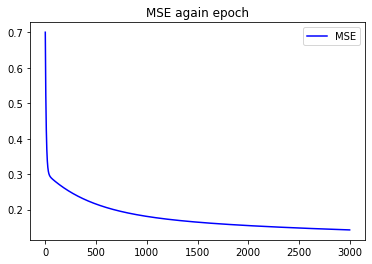

In [93]:
# test it and Y_real should be approach a1 + a2 * x + a3 * x^2
x = torch.FloatTensor([0, 1, 2, 3])
Y_real = torch.FloatTensor([0, 2, 4, 9])
A = torch.tensor([1.0, 0, 1.0], requires_grad=True)
optimizedA = fitData(Y_real, x, A)
print(optimizedA)

push to github